# Optimal Savings

```{include} _admonition/gpu.md
```

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

We will use the following imports:

In [2]:
import quantecon as qe
import jax
import jax.numpy as jnp
from collections import namedtuple
import matplotlib.pyplot as plt
import time

Let's check the GPU we are running

In [3]:
!nvidia-smi

Tue May 16 11:22:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P0    38W / 300W |      0MiB / 16160MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


Use 64 bit floats with JAX in order to match NumPy code
- By default, JAX uses 32-bit datatypes.
- By default, NumPy uses 64-bit datatypes.

In [4]:
jax.config.update("jax_enable_x64", True)

## Overview

We consider an optimal savings problem with CRRA utility and budget constraint

$$ W_{t+1} + C_t \leq R W_t + Y_t $$

We assume that labor income $(Y_t)$ is a discretized AR(1) process.

The right-hand side of the Bellman equation is 

$$   B((w, y), w', v) = u(Rw + y - w') + β \sum_{y'} v(w', y') Q(y, y'). $$

where

$$   u(c) = \frac{c^{1-\gamma}}{1-\gamma} $$

We use successive approximation for VFI.

In [5]:
def successive_approx(T,                     # Operator (callable)
                      x_0,                   # Initial condition
                      tolerance=1e-6,        # Error tolerance
                      max_iter=10_000,       # Max iteration bound
                      print_step=25,         # Print at multiples
                      verbose=False): 
    x = x_0
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        x_new = T(x)
        error = jnp.max(jnp.abs(x_new - x))
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"Terminated successfully in {k} iterations.")
    return x

## Model primitives

Here’s a `namedtuple` definition for storing parameters and grids.

In [6]:
Model = namedtuple('Model', 
                    ('β', 'R', 'γ', 'w_grid', 'y_grid', 'Q'))

In [7]:
def create_consumption_model(R=1.01,                    # Gross interest rate
                             β=0.98,                    # Discount factor
                             γ=2.5,                     # CRRA parameter
                             w_min=0.01,                # Min wealth
                             w_max=5.0,                 # Max wealth
                             w_size=150,                # Grid side
                             ρ=0.9, ν=0.1, y_size=100): # Income parameters
    """
    A function that takes in parameters and returns an instance of Model that
    contains data for the optimal savings problem.
    """
    w_grid = jnp.linspace(w_min, w_max, w_size)  
    mc = qe.tauchen(n=y_size, rho=ρ, sigma=ν)
    y_grid, Q = jnp.exp(mc.state_values), mc.P
    return Model(β=β, R=R, γ=γ, w_grid=w_grid, y_grid=y_grid, Q=Q)

In [8]:
def create_consumption_model_jax(R=1.01,                    # Gross interest rate
                             β=0.98,                    # Discount factor
                             γ=2.5,                     # CRRA parameter
                             w_min=0.01,                # Min wealth
                             w_max=5.0,                 # Max wealth
                             w_size=150,                # Grid side
                             ρ=0.9, ν=0.1, y_size=100): # Income parameters
    """
    A function that takes in parameters and returns a JAX-compatible version of Model that
    contains data for the optimal savings problem.
    """
    w_grid = jnp.linspace(w_min, w_max, w_size)
    mc = qe.tauchen(n=y_size, rho=ρ, sigma=ν)
    y_grid, Q = jnp.exp(mc.state_values), mc.P
    β, R, γ = jax.device_put([β, R, γ])
    w_grid, y_grid, Q = tuple(map(jax.device_put, [w_grid, y_grid, Q]))
    sizes = w_size, y_size
    return (β, R, γ), sizes, (w_grid, y_grid, Q)

Here's the right hand side of the Bellman equation:

In [9]:
def B(v, constants, sizes, arrays):
    """
    A vectorized version of the right-hand side of the Bellman equation 
    (before maximization), which is a 3D array representing

        B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)

    for all (w, y, w′).
    """

    # Unpack 
    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    # Compute current rewards r(w, y, wp) as array r[i, j, ip]
    w  = jnp.reshape(w_grid, (w_size, 1, 1))    # w[i]   ->  w[i, j, ip]
    y  = jnp.reshape(y_grid, (1, y_size, 1))    # z[j]   ->  z[i, j, ip]
    wp = jnp.reshape(w_grid, (1, 1, w_size))    # wp[ip] -> wp[i, j, ip]
    c = R * w + y - wp

    # Calculate continuation rewards at all combinations of (w, y, wp)
    v = jnp.reshape(v, (1, 1, w_size, y_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Q = jnp.reshape(Q, (1, y_size, 1, y_size))  # Q[j, jp]  -> Q[i, j, ip, jp]
    EV = jnp.sum(v * Q, axis=3)                 # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, c**(1-γ)/(1-γ) + β * EV, -jnp.inf)

## Operators

Now we define the policy operator $T_\sigma$

In [10]:
def compute_r_σ(σ, constants, sizes, arrays):
    """
    Compute the array r_σ[i, j] = r[i, j, σ[i, j]], which gives current
    rewards given policy σ.
    """

    # Unpack model
    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    # Compute r_σ[i, j]
    w = jnp.reshape(w_grid, (w_size, 1))
    y = jnp.reshape(y_grid, (1, y_size))
    wp = w_grid[σ]
    c = R * w + y - wp
    r_σ = c**(1-γ)/(1-γ)

    return r_σ

In [11]:
def T_σ(v, σ, constants, sizes, arrays):
    "The σ-policy operator."

    # Unpack model
    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    r_σ = compute_r_σ(σ, constants, sizes, arrays)

    # Compute the array v[σ[i, j], jp]
    yp_idx = jnp.arange(y_size)
    yp_idx = jnp.reshape(yp_idx, (1, 1, y_size))
    σ = jnp.reshape(σ, (w_size, y_size, 1))
    V = v[σ, yp_idx]      

    # Convert Q[j, jp] to Q[i, j, jp] 
    Q = jnp.reshape(Q, (1, y_size, y_size))

    # Calculate the expected sum Σ_jp v[σ[i, j], jp] * Q[i, j, jp]
    Ev = jnp.sum(V * Q, axis=2)

    return r_σ + β * jnp.sum(V * Q, axis=2)

and the Bellman operator $T$

In [12]:
def T(v, constants, sizes, arrays):
    "The Bellman operator."
    return jnp.max(B(v, constants, sizes, arrays), axis=2)

The next function computes a $v$-greedy policy given $v$

In [13]:
def get_greedy(v, constants, sizes, arrays):
    "Computes a v-greedy policy, returned as a set of indices."
    return jnp.argmax(B(v, constants, sizes, arrays), axis=2)

The function below computes the value $v_\sigma$ of following policy $\sigma$.

The basic problem is to solve the linear system

$$ v(w,y ) = u(Rw + y - \sigma(w, y)) + β \sum_{y'} v(\sigma(w, y), y') Q(y, y) $$

for $v$.  

It turns out to be helpful to rewrite this as 

$$ v(w,y) = r(w, y, \sigma(w, y)) + β \sum_{w', y'} v(w', y') P_\sigma(w, y, w', y') $$

where $P_\sigma(w, y, w', y') = 1\{w' = \sigma(w, y)\} Q(y, y')$.

We want to write this as $v = r_\sigma + P_\sigma v$ and then solve for $v$

Note, however,

* $v$ is a 2 index array, rather than a single vector.  
* $P_\sigma$ has four indices rather than 2 

The code below 

1. reshapes $v$ and $r_\sigma$ to 1D arrays and $P_\sigma$ to a matrix
2. solves the linear system
3. converts back to multi-index arrays.

In [14]:
def get_value(σ, constants, sizes, arrays):
    "Get the value v_σ of policy σ by inverting the linear map R_σ."

    # Unpack 
    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    r_σ = compute_r_σ(σ, constants, sizes, arrays)

    # Reduce R_σ to a function in v
    partial_R_σ = lambda v: R_σ(v, σ, constants, sizes, arrays)

    return jax.scipy.sparse.linalg.bicgstab(partial_R_σ, r_σ)[0]

In [15]:
def R_σ(v, σ, constants, sizes, arrays):
    """
    The value v_σ of a policy σ is defined as 

        v_σ = (I - β P_σ)^{-1} r_σ

    Here we set up the linear map v -> R_σ v, where R_σ := I - β P_σ. 

    In the consumption problem, this map can be expressed as

        (R_σ v)(w, y) = v(w, y) - β Σ_y′ v(σ(w, y), y′) Q(y, y′)

    Defining the map as above works in a more intuitive multi-index setting
    (e.g. working with v[i, j] rather than flattening v to a one-dimensional
    array) and avoids instantiating the large matrix P_σ.

    """

    β, R, γ = constants
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    # Set up the array v[σ[i, j], jp]
    zp_idx = jnp.arange(y_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, y_size))
    σ = jnp.reshape(σ, (w_size, y_size, 1))
    V = v[σ, zp_idx]

    # Expand Q[j, jp] to Q[i, j, jp]
    Q = jnp.reshape(Q, (1, y_size, y_size))

    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Q[j, jp]
    return v - β * jnp.sum(V * Q, axis=2)

## JIT compiled versions

In [16]:
B = jax.jit(B, static_argnums=(2,))
compute_r_σ = jax.jit(compute_r_σ, static_argnums=(2,))
T = jax.jit(T, static_argnums=(2,))
get_greedy = jax.jit(get_greedy, static_argnums=(2,))
get_value = jax.jit(get_value, static_argnums=(2,))
T_σ = jax.jit(T_σ, static_argnums=(3,))
R_σ = jax.jit(R_σ, static_argnums=(3,))

## Solvers

Now we define the solvers, which implement VFI, HPI and OPI.

In [17]:
def value_iteration(model, tol=1e-5):
    "Implements VFI."

    constants, sizes, arrays = model
    _T = lambda v: T(v, constants, sizes, arrays)
    vz = jnp.zeros(sizes)

    v_star = successive_approx(_T, vz, tolerance=tol)
    return get_greedy(v_star, constants, sizes, arrays)

In [18]:
def policy_iteration(model):
    "Howard policy iteration routine."
    constants, sizes, arrays = model
    vz = jnp.zeros(sizes)
    σ = jnp.zeros(sizes, dtype=int)
    i, error = 0, 1.0
    while error > 0:
        v_σ = get_value(σ, constants, sizes, arrays)
        σ_new = get_greedy(v_σ, constants, sizes, arrays)
        error = jnp.max(jnp.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        print(f"Concluded loop {i} with error {error}.")
    return σ

In [19]:
def optimistic_policy_iteration(model, tol=1e-5, m=10):
    "Implements the OPI routine."
    constants, sizes, arrays = model
    v = jnp.zeros(sizes)
    error = tol + 1
    while error > tol:
        last_v = v
        σ = get_greedy(v, constants, sizes, arrays)
        for _ in range(m):
            v = T_σ(v, σ, constants, sizes, arrays)
        error = jnp.max(jnp.abs(v - last_v))
    return get_greedy(v, constants, sizes, arrays)

## Plots

Create a JAX model for consumption, perform policy iteration, and plot the resulting optimal policy function.

Concluded loop 1 with error 77.
Concluded loop 2 with error 55.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 7.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 0.


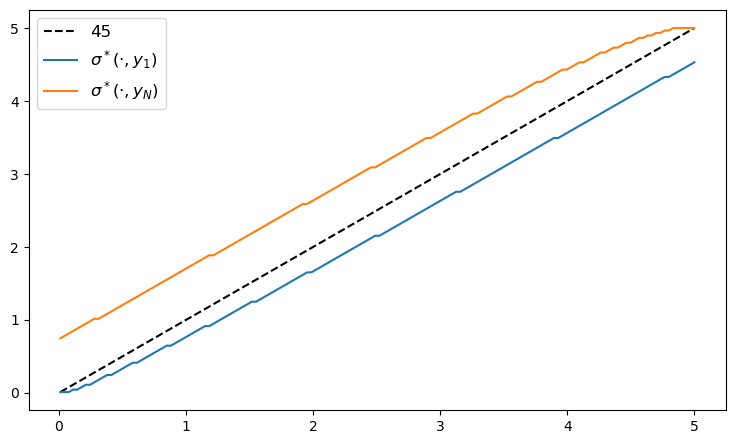

In [20]:
fontsize=12
model = create_consumption_model_jax()
# Unpack 
constants, sizes, arrays = model
β, R, γ = constants
w_size, y_size = sizes
w_grid, y_grid, Q = arrays
σ_star = policy_iteration(model)
fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(w_grid, w_grid, "k--", label="45")
ax.plot(w_grid, w_grid[σ_star[:, 1]], label="$\\sigma^*(\cdot, y_1)$")
ax.plot(w_grid, w_grid[σ_star[:, -1]], label="$\\sigma^*(\cdot, y_N)$")
ax.legend(fontsize=fontsize)
plt.show()

## Tests

Here's a quick test of the timing of each solver.

In [21]:
model = create_consumption_model_jax()

In [22]:
print("Starting HPI.")
start_time = time.time()
out = policy_iteration(model)
elapsed = time.time() - start_time
print(f"HPI completed in {elapsed} seconds.")

Starting HPI.
Concluded loop 1 with error 77.
Concluded loop 2 with error 55.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 7.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 0.
HPI completed in 0.03222322463989258 seconds.


In [23]:
print("Starting VFI.")
start_time = time.time()
out = value_iteration(model)
elapsed = time.time() - start_time
print(f"VFI(jax not in succ) completed in {elapsed} seconds.")

Starting VFI.


VFI(jax not in succ) completed in 0.8715875148773193 seconds.


In [24]:
print("Starting OPI.")
start_time = time.time()
out = optimistic_policy_iteration(model, m=100)
elapsed = time.time() - start_time
print(f"OPI completed in {elapsed} seconds.")

Starting OPI.


OPI completed in 0.3177609443664551 seconds.


Concluded loop 1 with error 77.
Concluded loop 2 with error 55.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 7.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 0.
policy_iteration completed in 0.03 seconds.


value_iteration completed in 0.31 seconds.
optimistic_policy_iteration completed in 0.17 seconds.


optimistic_policy_iteration completed in 0.13 seconds.
optimistic_policy_iteration completed in 0.18 seconds.


optimistic_policy_iteration completed in 0.27 seconds.


optimistic_policy_iteration completed in 0.29 seconds.


optimistic_policy_iteration completed in 0.40 seconds.


optimistic_policy_iteration completed in 0.43 seconds.


optimistic_policy_iteration completed in 0.49 seconds.


optimistic_policy_iteration completed in 0.52 seconds.


optimistic_policy_iteration completed in 0.57 seconds.


optimistic_policy_iteration completed in 0.67 seconds.


optimistic_policy_iteration completed in 1.02 seconds.


optimistic_policy_iteration completed in 0.84 seconds.


optimistic_policy_iteration completed in 1.16 seconds.


optimistic_policy_iteration completed in 1.35 seconds.


optimistic_policy_iteration completed in 1.45 seconds.


optimistic_policy_iteration completed in 1.52 seconds.


optimistic_policy_iteration completed in 1.61 seconds.


optimistic_policy_iteration completed in 1.50 seconds.


optimistic_policy_iteration completed in 1.66 seconds.


optimistic_policy_iteration completed in 1.36 seconds.


optimistic_policy_iteration completed in 1.42 seconds.


optimistic_policy_iteration completed in 1.45 seconds.


optimistic_policy_iteration completed in 1.54 seconds.


optimistic_policy_iteration completed in 1.61 seconds.


optimistic_policy_iteration completed in 1.86 seconds.


optimistic_policy_iteration completed in 2.45 seconds.


optimistic_policy_iteration completed in 2.19 seconds.


optimistic_policy_iteration completed in 2.67 seconds.


optimistic_policy_iteration completed in 2.81 seconds.


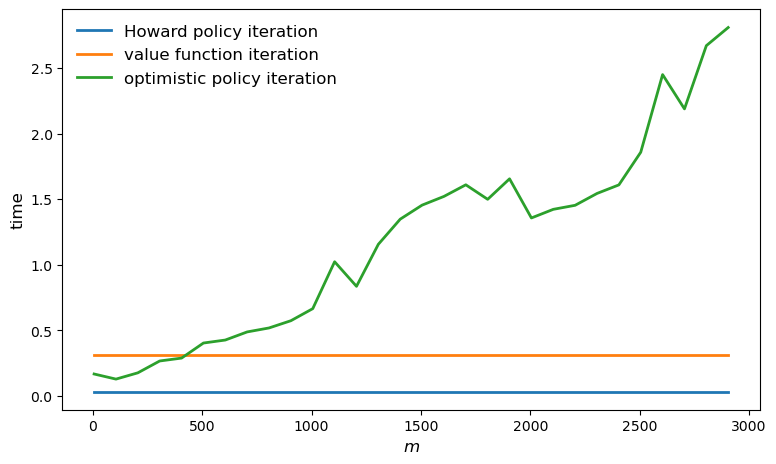

In [25]:
def run_algorithm(algorithm, model, **kwargs):
    start_time = time.time()
    result = algorithm(model, **kwargs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{algorithm.__name__} completed in {elapsed_time:.2f} seconds.")
    return result, elapsed_time

model = create_consumption_model_jax()
σ_pi, pi_time = run_algorithm(policy_iteration, model)
σ_vfi, vfi_time = run_algorithm(value_iteration, model, tol=1e-5)

m_vals = range(5, 3000, 100)
opi_times = []
for m in m_vals:
    σ_opi, opi_time = run_algorithm(optimistic_policy_iteration, model, m=m, tol=1e-5)
    opi_times.append(opi_time)

fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(m_vals, jnp.full(len(m_vals), pi_time), lw=2, label="Howard policy iteration")
ax.plot(m_vals, jnp.full(len(m_vals), vfi_time), lw=2, label="value function iteration")
ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
ax.legend(fontsize=fontsize, frameon=False)
ax.set_xlabel("$m$", fontsize=fontsize)
ax.set_ylabel("time", fontsize=fontsize)
plt.show()